In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit,leastsq
from BaselineRemoval import BaselineRemoval
from scipy.signal import find_peaks,peak_widths,peak_prominences

# automated Fitting

In [54]:
def baseline_rem(filename,
                 polynomial_degree=2,
                 plot_fig=False):
    '''
    
    The function takes in the data as filename and return and array in the form
    [x values for the data, baseline subtracted output]
    
    '''
    data=np.loadtxt(filename)
    x=np.arange(0,len(data),1)
    
    baseObj=BaselineRemoval(list(data))
    Imodpoly_output=baseObj.IModPoly(polynomial_degree)
    if plot_fig==True:
        plt.figure(figsize=[10,7])
        plt.plot(x,Imodpoly_output,'r-')
        plt.grid() 

    return [x,Imodpoly_output]
    

In [60]:
def get_init(x,
             data,
             p=0.1,
             h=0.5,
             plot_fig=False,
             save=False):
    
    '''
    Returns array in the form [number of peaks, peak position, fwhm of each peak, peak heights]
    '''
    
    peaks, _ = find_peaks(data, prominence=p,height=h)
    results_fwhm = peak_widths(data, peaks, rel_height=0.5)
    prominence=peak_prominences(data,peaks)
    if plot_fig==True:
        plt.figure(figsize=[10,7])
        plt.plot(data,'r-')
        plt.plot(peaks, data[peaks], "kx")
        plt.hlines(*results_fwhm[1:], color="C2")
        plt.grid()
        if save==True:
            plt.savefig("peaks_spot.jpeg")
    return [len(peaks),peaks,results_fwhm[0],results_fwhm[1]+prominence[0]]

In [204]:

#These function are used for fittting the guassian in the data


def gaussian(x, height, center, width):                 # returns a gaussian when x values, height, center and width are given
    return height*np.exp(-(x - center)**2/(2*width**2))
                                                                         
def ngaussians(n,data,coeffs):                         # return n number of guessian when number of gaussian, x value and 
    G=0                                                # the coeffs are given as flat array
    #print(type(coeffs))
    coeffs=list(coeffs)
    for i in range(n):
         G+=gaussian(data,*coeffs[3*i:3*(i+1)])
    return G

def errfunc(params,n,x,y):                            # acts as the cost function for least squares algorithm   
    return (ngaussians(n,x,params) - y)**2         



In [211]:
def automated_fitting(filename,
                      poly_deg=2,
                      prominence=0.1,
                      height_threshold=0.5,
                      plot_baseline_removed=False,
                      save_first_estimate=False,
                      plot_first_estimate=False,
                      plot_final_gaussian_fit=True,
                      save_final_gaussian_fit=True,
                      save_name=None
                     ):
    
    '''
    This function combines all the algorithms above to provide the gaussian fit for the input data
    
    ----------------------------------- WORKING ------------------------------------
    1) Estimates the baseline substracted curve using baseline_rem function
    2) calls init function to calculate the approximate number of peaks(n) and initial values for the guassian fitting
    3) Uses the number of peaks values(n) to fit a n-guassian curve to data using scipy.optimize.leastsq function 
    --------------------------------------------------------------------------------
    
    
    filename: name of the data file as str
    poly_deg : degree of the polynomial to fit the baseline
    prominence: prominence of the peak,DEFAULT value=0.5
    height_threhold= minimum threshold height peak to be considered
    

    plot and save parameters are for plotting and saving each stages
    
    '''
    
    k=baseline_rem(filename,polynomial_degree=poly_deg,plot_fig=plot_baseline_removed)
    f=get_init(k[0],k[1],p=prominence,h=height_threshold,plot_fig=plot_first_estimate,save=save_first_estimate)
    
    init=[]
    for i in range(f[0]):
        init.append([f[3][i],f[1][i],f[2][i]])
    optim, success = leastsq(errfunc, init, args=(f[0],k[0],k[1]))
    
    if plot_final_gaussian_fit==True:
        plt.figure(figsize=[10,7])
        plt.plot(k[0],k[1],'k-')
        for i in range(f[0]):
            plt.plot(k[0], gaussian(k[0], optim[3*i], optim[3*i+1], optim[3*i+2]),lw=2, ls='--', label='Gaussian'+str(i+1),alpha=0.6)
            
        plt.plot(k[0], ngaussians(f[0],k[0], optim),lw=2,c='r', ls='-', label='fit of '+str(f[0])+ ' Gaussians')
        plt.grid()
        plt.legend(fontsize=14)
        if save_final_gaussian_fit==True:
            if save_name:
                plt.savefig(save_name+'.jpeg')
            else:
                plt.savefig('gaussian_fit.jpeg')
        plt.show()

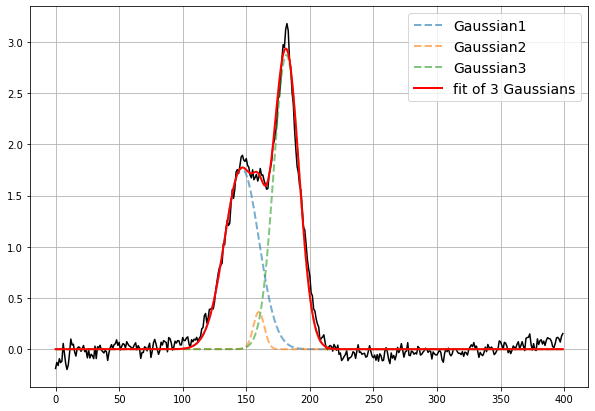

In [213]:
automated_fitting('gl-140',save_name='gl-140_fit')

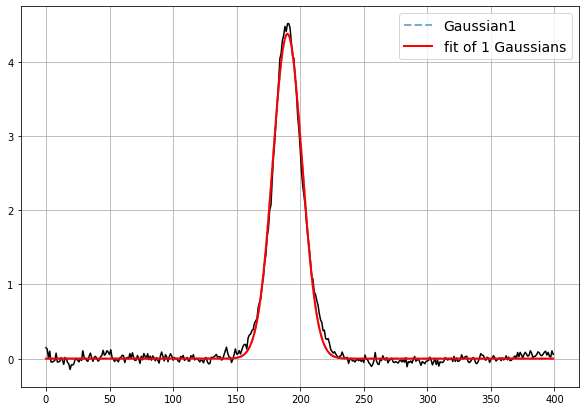

In [217]:
automated_fitting('gl-170',save_name='gl-170_fit')

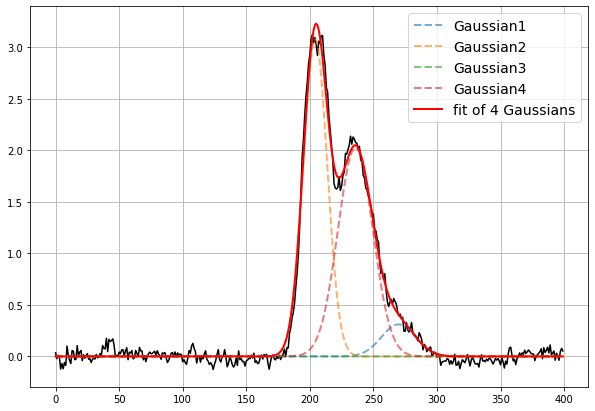

In [214]:
automated_fitting('gl140',save_name='gl140_fit')

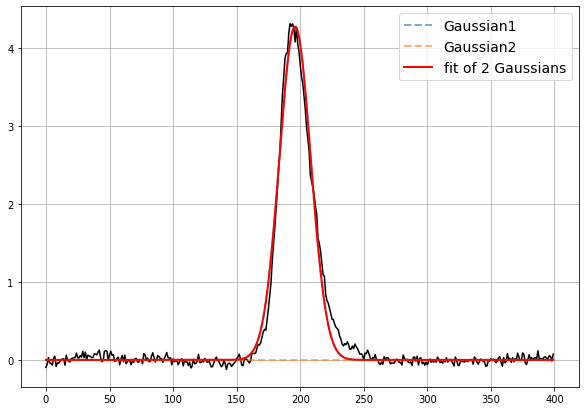

In [215]:
automated_fitting('gl180',save_name='gl180_fit')

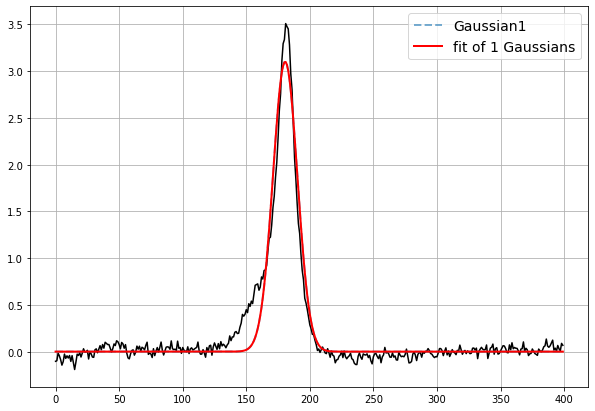

In [216]:
automated_fitting('gl-153',save_name='gl-153_fit')